# Entitlements in TOC-eligible parcels

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import intake
import boto3

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

In [ ]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [72]:
parcels = gpd.read_file(f'zip+s3://{bucket_name}/gis/intermediate/la_parcels_toc.zip')

display(parcels.TOC_Tier.value_counts())
parcels = parcels[parcels.TOC_Tier > 0]

0    442562
1    148994
3    110153
2     65653
4      7844
Name: TOC_Tier, dtype: int64

In [ ]:
cases = catalog.pcts.tCASE.read()
app = catalog.pcts.tAPLC.read()
geo_info = catalog.pcts.tPROP_GEO_INFO.read()
la_prop = catalog.pcts.tLA_PROP.read()

In [ ]:
cases1 = cases[['CASE_ID', 'APLC_ID', 'CASE_NBR', 'CASE_SEQ_NBR', 'CASE_YR_NBR', 'CASE_ACTION_ID', 'ADM_ACTION_DT']]
app1 = app[['APLC_ID', 'PROJ_DESC_TXT']]
geo_info1 = geo_info[['CASE_ID', 'PROP_ID']]
la_prop1 = la_prop[la_prop.ASSR_PRCL_NBR.notna()][['PROP_ID', 'ASSR_PRCL_NBR']]

In [ ]:
print(f'# obs in cases1: {len(cases1)}')
print(f'# unique CASE_ID in cases1: {cases1.CASE_ID.nunique()}')
display(cases1.head())

In [ ]:
print(f'# obs in geo_info1: {len(geo_info1)}')
print(f'# unique CASE_ID in geo_info1: {geo_info1.CASE_ID.nunique()}')
print(f'# unique PROP_ID in geo_info1: {geo_info1.PROP_ID.nunique()}')
display(geo_info1.head())

# There can be multiple CASE_IDs that take place on same PROP_ID. Makes sense, over time, the same parcel might have multiple entitlements
# Also makes sense for there to be multiple PROP_IDs that appear here

In [ ]:
print(f'# obs in la_prop1: {len(la_prop1)}')
print(f'# unique PROP_ID in la_prop1: {la_prop1.PROP_ID.nunique()}')
print(f'# unique ASSR_PRCL_NBR in la_prop1: {la_prop1.ASSR_PRCL_NBR.nunique()}')
display(la_prop1.head())

# If PROP_ID is unique...that means every time a parcel has an entitlemnet, a unique PROP_ID is generated
# That would explain why the same ASSR_PRCL_NBR has multiple PROP_IDs

## Only keep cases from 2016 and after

In [ ]:
cases2 = cases1[cases1.CASE_YR_NBR >= 2016]

In [ ]:
print(f'# obs in cases1: {len(cases1)}')
print(f'# obs in cases2: {len(cases2)}')
print(f'# unique CASE_ID in cases2: {cases2.CASE_ID.nunique()}')
print(f'# unique CASE_SEQ_NBR in cases2: {cases2.CASE_SEQ_NBR.nunique()}')
display(cases2.head())

In [ ]:
cases2[cases2.CASE_SEQ_NBR==1169].sort_values(['CASE_SEQ_NBR', 'CASE_YR_NBR'], ascending = [True, True])

## Merge with geo_info, la_prop, parcels to ID the parcels that are TOC-eligible and have entitlements

In [ ]:
m1 = pd.merge(cases2, geo_info1, on = 'CASE_ID', how = 'inner', validate = '1:m')

In [ ]:
m2 = pd.merge(m1, la_prop1, on = 'PROP_ID', how = 'inner', validate = 'm:1')

In [ ]:
print(f'# obs in m2: {len(m2)}')
print(f'# unique CASE_ID in m2: {m2.CASE_ID.nunique()}')
print(f'# unique CASE_SEQ_NBR in m2: {m2.CASE_SEQ_NBR.nunique()}')
print(f'# unique PROP_ID in m2: {m2.PROP_ID.nunique()}')
print(f'# unique ASSR_PRCL_NBR in m2: {m2.ASSR_PRCL_NBR.nunique()}')
display(m2.head())

In [ ]:
m3 = pd.merge(m2, parcels, left_on = 'ASSR_PRCL_NBR', right_on = 'AIN', how = 'inner', validate = 'm:1')

In [ ]:
print(f'# obs in m3: {len(m3)}')
print(f'# unique CASE_ID in m3: {m3.CASE_ID.nunique()}')
print(f'# unique CASE_SEQ_NBR in m3: {m3.CASE_SEQ_NBR.nunique()}')
print(f'# unique PROP_ID in m3: {m3.PROP_ID.nunique()}')
print(f'# unique ASSR_PRCL_NBR in m3: {m3.ASSR_PRCL_NBR.nunique()}')
display(m3.head())

## Join parcels to zoning
* Subset by eligible zones, see how many TOC-eligible parcels also fall into eligible zones

In [ ]:
zoning = gpd.read_file(f's3://{bucket_name}/gis/raw/parsed_zoning.geojson')

In [ ]:
eligible_zones = ['R2', 'R3', 'RAS3', 'R4', 'RAS4', 'R5', 
                  'RD1.5', 'RD2', 'RD3', 'RD4', 'RD5', 'RD6', 
                  'C1', 'C2', 'C4', 'C5']

eligible_zoning = zoning[zoning.zone_class.isin(eligible_zones)]

In [73]:
parcels['centroid'] = parcels.geometry.centroid

In [74]:
parcels2 = parcels.set_geometry('centroid')
parcels2 = parcels2[['AIN', 'TOC_Tier', 'centroid']]
parcels2['x'] = parcels2.centroid.x
parcels2['y'] = parcels2.centroid.y

In [ ]:
parcels2['obs'] = parcels2.groupby(['x', 'y']).cumcount() + 1
parcels2['num_obs'] = parcels2.groupby(['x', 'y'])['obs'].transform('max')

In [ ]:
parcels2.to_file(driver = 'GeoJSON', filename = '../gis/parcels_with_toc.geojson')

In [92]:
parcels.drop(columns = 'centroid').to_file(driver = 'GeoJSON', filename = '../gis/toc_eligible_parcels.geojson')

In [ ]:
parcels_with_zoning = gpd.sjoin(parcels2, eligible_zoning, how = 'inner', op = 'intersects').drop(columns = ['index_right'])

In [ ]:
print(f'# obs in parcels2: {len(parcels2)}')
print(f'# obs in parcels_with_zoning: {len(parcels_with_zoning)}')
print(f'# unique AIN in parcels2: {parcels2.AIN.nunique()}')
print(f'# unique AIN in parcels_with_zoning: {parcels_with_zoning.AIN.nunique()}')
display(parcels_with_zoning.head())

In [ ]:
# Merge in zoning and TOC info about the parcel
m4 = pd.merge(m3, parcels_with_zoning, on = 'AIN', how = 'inner')

In [ ]:
# Drop duplicates
display(m4.num_obs.value_counts())
m5 = m4[m4.obs == 1]

In [ ]:
# Merge in project description
m6 = pd.merge(m5, app1, on = 'APLC_ID', how = 'inner', validate = 'm:1')

In [ ]:
# For same CASE_SEQ_NBR, keep the max CASE_ID
m6['max_CASE_ID'] = m6.groupby(['CASE_SEQ_NBR', 'CASE_YR_NBR'])['CASE_ID'].transform('max')
m6 = m6[m6.CASE_ID == m6.max_CASE_ID]

In [ ]:
drop = ['centroid', 'x', 'y', 'obs', 'num_obs', 
        'CASE_ID', 'max_CASE_ID', 'APLC_ID', 'ASSR_PRCL_NBR', 'PROP_ID', 
       'TOC_Tier_y']

m6 = m6.drop(columns = drop)
m6.rename(columns = {'TOC_Tier_x':'TOC_Tier'}, inplace = True)

In [ ]:
m6.drop(columns = 'geometry').to_parquet('../gis/m6.parquet')

In [ ]:
print(f'# obs in m6: {len(m6)}')
print(f'# unique CASE_SEQ_NBR in m6: {m6.CASE_SEQ_NBR.nunique()}')
display(m6.sort_values(['CASE_SEQ_NBR', 'CASE_YR_NBR']).head(10))

In [ ]:
import pcts_parser

parsed_col_names = ['suffix']

def parse_pcts(row):
    try:
        z = pcts_parser.PCTSCaseNumber(row.CASE_NBR)
        return pd.Series([z.suffix], index = parsed_col_names)
    except ValueError:
        return pd.Series([z.suffix], index = parsed_col_names)

parsed = m6.apply(parse_pcts, axis = 1)

m7 = pd.concat([m6, parsed], axis = 1)

In [ ]:
m7.drop(columns = 'geometry').to_parquet('../gis/m7.parquet')

## Additional subsetting for for TOC-eligible parcels

In [3]:
m7 = pd.read_parquet('../gis/m7.parquet')

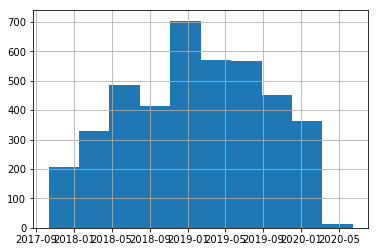

In [56]:
m7[(m7.CASE_NBR.str.contains('TOC')) & (m7.ADM_ACTION_DT.dt.year <= 2020) & (m7.ADM_ACTION_DT.dt.year >=2016)].ADM_ACTION_DT.hist()

In [7]:
# Say approved cases are ones with ADM_ACTION_DT
m8 = m7[m7.ADM_ACTION_DT.notna()]

In [10]:
# Create new id variable that is just seq number and year. Need a way to get rid of duplicate cases.
m8['id'] = m8.CASE_SEQ_NBR.astype(int).astype(str) + '_' + m8.CASE_YR_NBR.astype(int).astype(str)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [4]:
""" 
split = m7.suffix.apply(pd.Series)
split.rename(columns = {0: 'one', 1: 'two', 2: 'three',
                        3: 'four', 4: 'five', 5: 'six',  6: 'seven'}, inplace = True)  

for col in ['one', 'two', 'three', 'fou7', 'five', 'six', 'seven']:
    split[col] = split[col].fillna('')
    
m7 = pd.concat([m7, split], axis = 1)
"""

In [15]:
# Tag case as TOC or not
m8['is_TOC'] = m8.CASE_NBR.str.contains('TOC').astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
keep_col = ['CASE_NBR', 'id', 'CASE_ACTION_ID', 'ADM_ACTION_DT', 'AIN', 'TOC_Tier', 'zone_class', 
           'suffix', 'is_TOC']

m8 = m8[keep_col]

m8.to_parquet('../gis/m8.parquet')

In [20]:
m8 = pd.read_parquet('../gis/m8.parquet')

## Make into parcel level df

In [21]:
m8.head()

,CASE_NBR,id,CASE_ACTION_ID,ADM_ACTION_DT,AIN,TOC_Tier,zone_class,suffix,is_TOC
24,PAR-2018-4361-TOC,4361_2018,14.0,2018-09-20,2321007011,1,R3,[TOC],1
25,ADM-2018-2684-TOC,2684_2018,13.0,2018-05-09,2321007011,1,R3,[TOC],1
28,ADM-2020-50-RDP,50_2020,1.0,2020-01-03,5547019010,3,C4,[RDP],0
29,ADM-2020-48-RDP,48_2020,1.0,2020-01-03,2350006029,4,R4,[RDP],0
30,ADM-2020-49-RDP,49_2020,1.0,2020-01-03,2350006029,4,R4,[RDP],0


In [26]:
m9 = m8.groupby(['AIN', 'TOC_Tier', 'zone_class', 'is_TOC']).agg({'id':'count'}).reset_index()

In [31]:
# Make wide
m9['num_TOC'] = m9.apply(lambda row: row.id if row.is_TOC == 1 else np.nan, axis = 1) 
m9['num_nonTOC'] = m9.apply(lambda row: row.id if row.is_TOC == 0 else np.nan, axis = 1)

In [40]:
# If there are multiple obs for the same AIN, fill the NaNs with the max from the other column, so we can just drop duplicates after
for col in ['num_TOC', 'num_nonTOC']:
    m9[col] = m9[col].fillna(m9.groupby('AIN')[col].transform('max'))

In [52]:
m10 = m9.drop_duplicates(subset = ['AIN', 'TOC_Tier', 'zone_class', 'num_TOC', 'num_nonTOC'])

for col in ['num_TOC', 'num_nonTOC']:
    m10[col] = m10[col].fillna(0).astype(int)

m10 = m10.drop(columns = ['is_TOC', 'id'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [53]:
m10.head()

,AIN,TOC_Tier,zone_class,num_TOC,num_nonTOC
0,2023007025,2,C1,0,2
1,2038040006,1,C2,0,2
2,2111018013,2,C2,0,14
3,2111019002,2,C2,0,1
4,2111025011,2,C2,0,3


In [64]:
toc_parcels = m10[m10.num_TOC > 0]
non_toc_parcels = m10[m10.num_nonTOC > 0]
have_both_parcels = m10[(m10.num_TOC > 0) & (m10.num_nonTOC > 0)]

print(f'# parcels: {len(m10)}')
print(f'# parcels with TOC entitlements: {len(toc_parcels)}')
print(f'# parcels with non TOC entitlements: {len(non_toc_parcels)}')
print(f'# parcels with both TOC and non TOC entitlements: {len(have_both_parcels)}')
print(f'double check sum: {len(toc_parcels) + len(non_toc_parcels) - len(have_both_parcels)}')

# parcels: 2930
# parcels with TOC entitlements: 1156
# parcels with non TOC entitlements: 1845
# parcels with both TOC and non TOC entitlements: 71
double check sum: 2930


In [65]:
print(f'% parcels with TOC entitlements: {len(toc_parcels) / len(m10)}')
print(f'% parcels with non TOC entitlements: {len(non_toc_parcels) / len(m10)}')
print(f'% parcels with both entitlements: {len(have_both_parcels) / len(m10)}')

% parcels with TOC entitlements: 0.3945392491467577
% parcels with non TOC entitlements: 0.6296928327645052
% parcels with both entitlements: 0.024232081911262797


In [67]:
m10.TOC_Tier.value_counts()

3    1421
1     725
2     605
4     179
Name: TOC_Tier, dtype: int64

In [70]:
toc_parcels.zone_class.value_counts()

C2       441
R3       358
R4       191
C4        72
RD1.5     46
RD2       24
R2         7
RAS4       5
R5         4
RAS3       4
C1         4
Name: zone_class, dtype: int64

In [71]:
non_toc_parcels.zone_class.value_counts()

C2       607
R2       330
RD1.5    209
RD2      195
C4       183
R3       160
R4        57
RD3       54
C1        18
C5        17
R5        15
Name: zone_class, dtype: int64

In [75]:
parcels2.head()

,AIN,TOC_Tier,centroid,x,y
1356,2010004010,1,POINT (6378559.967 1908406.082),6.378560e+06,1.908406e+06
1357,2010004011,1,POINT (6378584.342 1908296.034),6.378584e+06,1.908296e+06
1368,2010004024,1,POINT (6378595.550 1908030.427),6.378596e+06,1.908030e+06
1369,2010004025,1,POINT (6378664.367 1908038.708),6.378664e+06,1.908039e+06
1370,2010004026,1,POINT (6378759.826 1908027.493),6.378760e+06,1.908027e+06


In [85]:
m11 = pd.merge(m10, parcels2, on = ['AIN', 'TOC_Tier'], how = 'inner')

m11.rename(columns = {'centroid':'geometry'}, inplace = True)
m11 = gpd.GeoDataFrame(m11)
m11.crs = {'init':'epsg:2229'}

In [88]:
toc_parcels = m11[m11.num_TOC > 0]
non_toc_parcels = m11[m11.num_nonTOC > 0]
have_both_parcels = m11[(m11.num_TOC > 0) & (m11.num_nonTOC > 0)]

In [90]:
m11.drop(columns = ['x', 'y']).to_file(driver = 'GeoJSON', filename = '../gis/toc_eligible_parcels_with_entitlements.geojson')